In [ ]:
#import required libraries
from __future__ import division, print_function, unicode_literals
import numpy as np
import pandas as pd
from sklearn.metrics import roc_curve,auc,classification_report,confusion_matrix
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from random import shuffle
from skimage.transform import resize
import os


Connecting to Google drive to access the uploaded dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Once the drive is mounted, read the train.csv file into a Dataframe and display top 5 rows of the file

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/plant-pathology-2021-fgvc8/train.csv')
df.head(5)

,image,labels
0,800113bb65efe69e.jpg,healthy
1,8002cb321f8bfcdf.jpg,scab frog_eye_leaf_spot complex
2,80070f7fb5e2ccaa.jpg,scab
3,80077517781fb94f.jpg,scab
4,800cbf0ff87721f8.jpg,complex


Changing the base directory path to access the uploaded dataset.
The images will be resized to 224 * 224 dimension for pre-processing.

In [ ]:
BATCH_SIZE = 1000
TARGET_SIZE = 224
BASE_DIR = "/content/drive/MyDrive/plant-pathology-2021-fgvc8"


Displaying seaborn barplot to show the distribution of 12 Foliar disease classes present in the input dataset

C:\Python\Python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


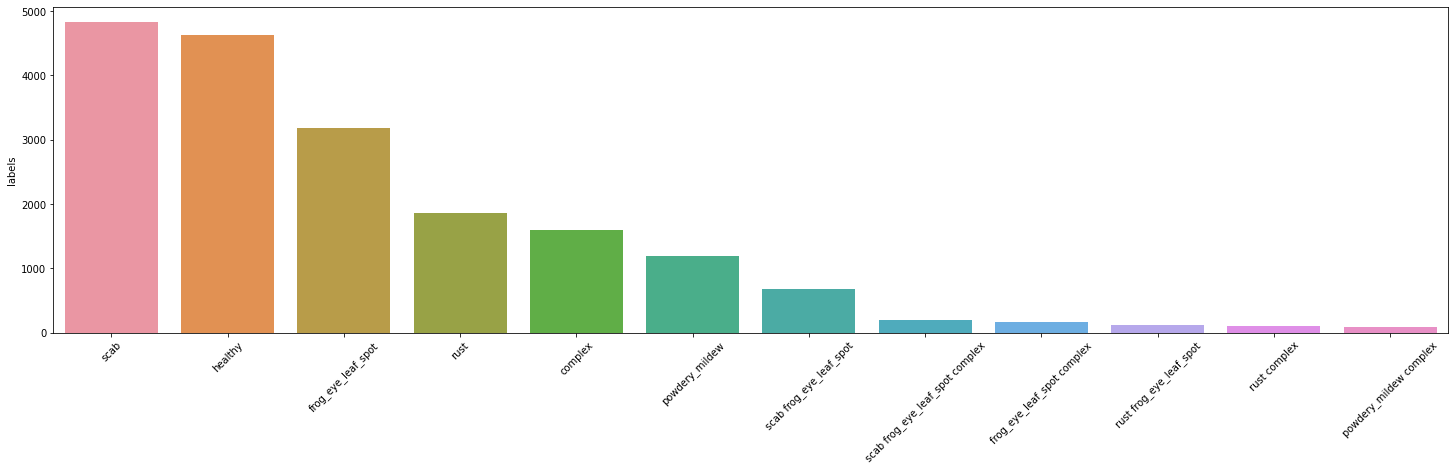

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize =(25, 6))
labels = sns.barplot(df['labels'].value_counts().index, df['labels'].value_counts())
for item in labels.get_xticklabels():
    item.set_rotation(45)

Using Gaussian Blur for removing extra noise from the images

In [ ]:
def preprocess(image):
    #Converting to numpy array from numpy tensor with rank 3
    image = np.array(image, dtype=np.uint8)
    #Gaussian Blur
    gaussian_blur = cv2.GaussianBlur(image,(5,5),0)
    img = np.asarray(gaussian_blur, dtype=np.float64)
    return img

In [ ]:
#Converting labels to string to use sparse class mode
df.label = df.labels.astype('str')

<ipython-input-26-2a96111bfb73>:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.label = df.labels.astype('str')


In [ ]:
from keras.preprocessing.image import ImageDataGenerator

ImageDataGenerator is used to perform data augmentation techniques like Rotation, Horizontal Flipping, Zooming, Shearing, Contrasting and Shifting on 1000 train images to create a new dataset.


In [ ]:

datagen = ImageDataGenerator(rescale=1.0/255,
                             featurewise_center=True,
                             featurewise_std_normalization=True,
                             rotation_range=30,
                             width_shift_range=0.3,
                             height_shift_range=0.3,
                             shear_range=15.0,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             brightness_range=[0.2, 0.8],
                             validation_split=0.2,
                             fill_mode='nearest',
                             preprocessing_function=preprocess)
                             


In [ ]:
train_datagen = datagen.flow_from_dataframe(df,
                                            directory = os.path.join(BASE_DIR, "train_images_Final"),
                                            subset = "training",
                                            x_col = "image",
                                            y_col = "labels",
                                            target_size = (TARGET_SIZE, TARGET_SIZE),
                                            batch_size = BATCH_SIZE,
                                            class_mode = "sparse")

#Validation
validation_datagen = ImageDataGenerator(rescale=1.0/255,
                                        validation_split=0.2,
                                       preprocessing_function=preprocess)
                             
valid_datagen = validation_datagen.flow_from_dataframe(df,
                                            directory = os.path.join(BASE_DIR, "train_images_Final"),
                                            subset = "validation",
                                            x_col = "image",
                                            y_col = "labels",
                                            target_size = (TARGET_SIZE, TARGET_SIZE),
                                            batch_size = BATCH_SIZE,
                                            class_mode = "sparse")

Found 14906 validated image filenames belonging to 12 classes.
Found 3726 validated image filenames belonging to 12 classes.


 Plotting the Augmented leaf images to see the variations in pose, orientation and view of the original input leaf images.

In [ ]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 7, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

C:\Python\Python38\lib\site-packages\keras_preprocessing\image\image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Python\Python38\lib\site-packages\keras_preprocessing\image\image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


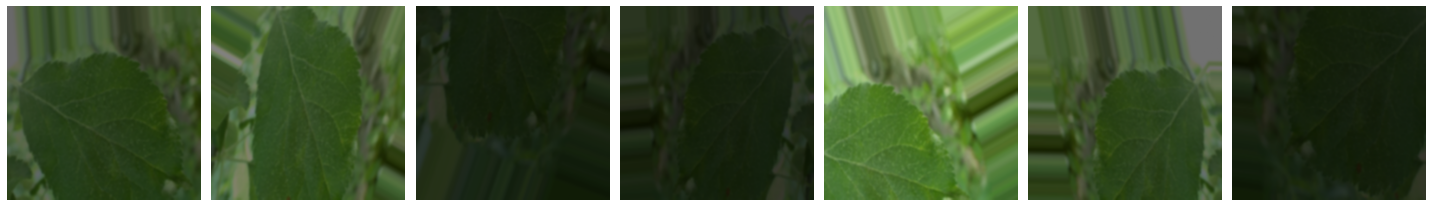

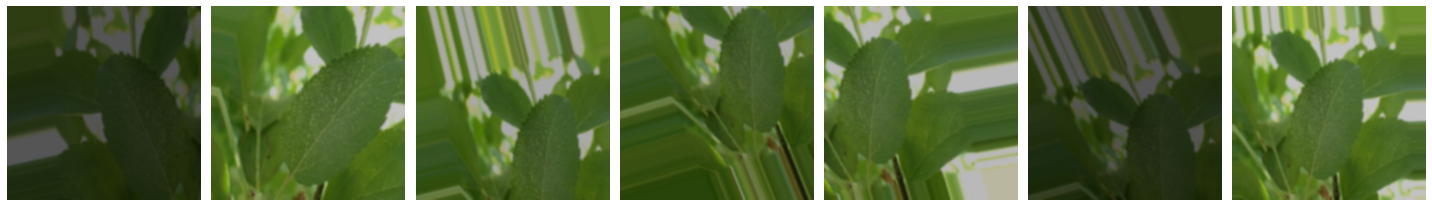

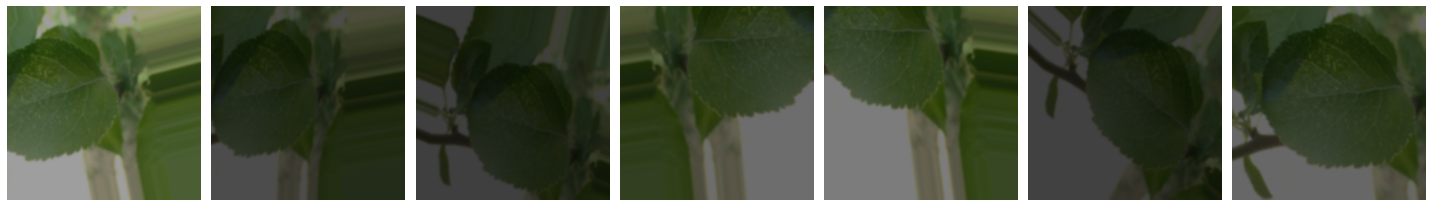

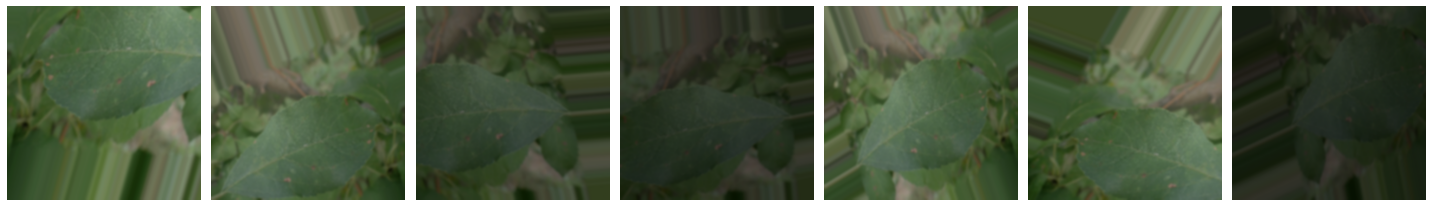

In [ ]:
augmented_images = [train_datagen[0][0][0] for i in range(7)]
plotImages(augmented_images)
augmented_images = [train_datagen[1][0][0] for i in range(7)]
plotImages(augmented_images)
augmented_images = [train_datagen[2][0][0] for i in range(7)]
plotImages(augmented_images)
augmented_images = [train_datagen[3][0][0] for i in range(7)]
plotImages(augmented_images)

In [ ]:
X_train, y_train = train_datagen.next()

C:\Python\Python38\lib\site-packages\keras_preprocessing\image\image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Python\Python38\lib\site-packages\keras_preprocessing\image\image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


In [ ]:
X_train.shape

(1000, 224, 224, 3)

In [ ]:
X_valid, y_valid = valid_datagen.next()

In [ ]:
x=[]
for i in y_train:
    i = int(i)
    x.append(i)
     

Converting the RGB leaf images to grayscale images. 3 Channels for RGB images is converted to 1 channel for grayscale.

In [ ]:
from tensorflow.keras.utils import to_categorical

X_train = X_train.reshape(-1, 28, 28, 1).astype('float32') / 255.
X_valid = X_valid.reshape(-1, 28, 28, 1).astype('float32') / 255.

In [ ]:
X_train.shape

(192000, 28, 28, 1)

In [ ]:
X_valid.shape

(192000, 28, 28, 1)

Sample features of leaf images are converted to grayscale and displayed.

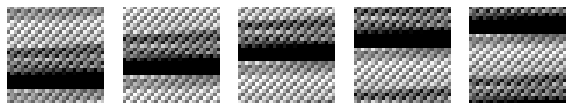

In [ ]:
n_samples = 5

plt.figure(figsize=(n_samples * 2, 3))
for index in range(n_samples):
    plt.subplot(1, n_samples, index + 1)
    sample_image = X_train[index].reshape(28, 28)
    plt.imshow(sample_image, cmap="binary")
    plt.axis("off")

plt.show()

In [ ]:
y_train[:n_samples]

array([1., 9., 0., 6., 9.], dtype=float32)

Building the AppleCaps - Capsule Network to classify these images. Labels → Mask, and Input Images → Reconstruction Loss.
 

                            Loss
                              ↑
                    ┌─────────┴─────────┐
      Labels → Margin Loss      Reconstruction Loss
                    ↑                   ↑
                  Length             Decoder
                    ↑                   ↑ 
             Digit Capsules ────Mask────┘
               ↖↑↗ ↖↑↗ ↖↑↗
             Primary Capsules
                    ↑      
               Input Leaf Images


In [ ]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
X = tf.compat.v1.placeholder(shape=[None, 28, 28, 1], dtype=tf.float32, name="X")

The input image is convoluted with the filter kernel which is of dimension (9,9,1,256) where 256 refers to the convolutional filters. After the convolution is done, the resultant block is of size (20,20,256) with 256 channels. The number of parameters that will be trained equals 20,992 which is obtained from the calculation 256 * (9 * 9 + 1). The resultant block is further convoluted with a filter block of dimension (9,9,256,256) to obtain a resultant block of (6,6,256) size.

In [ ]:
caps1_n_maps = 32
caps1_n_caps = caps1_n_maps * 6 * 6  # 1152 primary capsules
caps1_n_dims = 8

In [ ]:
conv1_params = {
    "filters": 256,
    "kernel_size": 9,
    "strides": 1,
    "padding": "valid",
    "activation": tf.nn.relu,
}

conv2_params = {
    "filters": caps1_n_maps * caps1_n_dims, # 256 convolutional filters
    "kernel_size": 9,
    "strides": 2,
    "padding": "valid",
    "activation": tf.nn.relu
}

In [ ]:
conv1 = tf.compat.v1.layers.conv2d(X, name="conv1", **conv1_params)
conv2 = tf.compat.v1.layers.conv2d(conv1, name="conv2", **conv2_params)

<ipython-input-28-ed6c9f91b4f7>:1: UserWarning: `tf.layers.conv2d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2D` instead.
  conv1 = tf.compat.v1.layers.conv2d(X, name="conv1", **conv1_params)
C:\Python\Python38\lib\site-packages\keras\legacy_tf_layers\convolutional.py:563: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
<ipython-input-28-ed6c9f91b4f7>:2: UserWarning: `tf.layers.conv2d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2D` instead.
  conv2 = tf.compat.v1.layers.conv2d(conv1, name="conv2", **conv2_params)


The reshaping process will reshape the final block of the (6,6,256) dimension into 32 blocks with the dimension of (6,6,8). These 6 * 6 blocks contain all the vector outputs that define the position, orientation, texture and height of the object in an 8-dimensional vector. The total 8D vectors will be equal to 6 * 6 * 32 = 1152 vectors.

In [ ]:
caps1_raw = tf.reshape(conv2, [-1, caps1_n_caps, caps1_n_dims],
                       name="caps1_raw")

The length of each vector refers to the probability of an object if it is present or not in an image and should not exceed the value 1. The squashing function then comes into the picture which squashes all the vectors with a value more than 1 to a probability range between 0 to 1.

In [ ]:
def squash(s, axis=-1, epsilon=1e-7, name=None):
    #with tf.name_scope(name, default_name="squash"):
    with tf.name_scope(name):
        #squared_norm = tf.reduce_sum(tf.square(s), axis=axis,
        #                             keep_dims=True)
        squared_norm = tf.reduce_sum(tf.square(s), axis=axis,
                                     keepdims=True)
        safe_norm = tf.sqrt(squared_norm + epsilon)
        squash_factor = squared_norm / (1. + squared_norm)
        unit_vector = s / safe_norm
        return squash_factor * unit_vector

In [ ]:
caps1_output = squash(caps1_raw, name="caps1_output")

In [ ]:
caps2_n_caps = 11
caps2_n_dims = 16

In [ ]:
init_sigma = 0.1

#W_init = tf.random_normal(
W_init = tf.random.normal(
    shape=(1, caps1_n_caps, caps2_n_caps, caps2_n_dims, caps1_n_dims),
    stddev=init_sigma, dtype=tf.float32, name="W_init")
W = tf.Variable(W_init, name="W")

In [ ]:
batch_size = tf.shape(X)[0]
W_tiled = tf.tile(W, [batch_size, 1, 1, 1, 1], name="W_tiled")

In [ ]:
caps1_output_expanded = tf.expand_dims(caps1_output, -1,
                                       name="caps1_output_expanded")
caps1_output_tile = tf.expand_dims(caps1_output_expanded, 2,
                                   name="caps1_output_tile")
caps1_output_tiled = tf.tile(caps1_output_tile, [1, 1, caps2_n_caps, 1, 1],
                             name="caps1_output_tiled")

In [ ]:
W_tiled

<tf.Tensor 'W_tiled:0' shape=(None, 1152, 11, 16, 8) dtype=float32>

In [ ]:
caps2_predicted = tf.matmul(W_tiled, caps1_output_tiled,
                            name="caps2_predicted")

In [ ]:
caps2_predicted

<tf.Tensor 'caps2_predicted:0' shape=(None, 1152, 11, 16, 1) dtype=float32>

In [ ]:
raw_weights = tf.zeros([batch_size, caps1_n_caps, caps2_n_caps, 1, 1],
                       dtype=np.float32, name="raw_weights")

# Routing Weights 

# Round 1

In [ ]:
routing_weights = tf.nn.softmax(raw_weights, name="routing_weights")

In [ ]:
weighted_predictions = tf.multiply(routing_weights, caps2_predicted,
                                   name="weighted_predictions")
weighted_sum = tf.reduce_sum(weighted_predictions, axis=1, keepdims=True,
                             name="weighted_sum")

In [ ]:
caps2_output_round_1 = squash(weighted_sum, axis=-2,
                              name="caps2_output_round_1")

In [ ]:
caps2_output_round_1

<tf.Tensor 'caps2_output_round_1/mul:0' shape=(None, 1, 11, 16, 1) dtype=float32>

In [ ]:
caps2_predicted

<tf.Tensor 'caps2_predicted:0' shape=(None, 1152, 11, 16, 1) dtype=float32>

In [ ]:
caps2_output_round_1

<tf.Tensor 'caps2_output_round_1/mul:0' shape=(None, 1, 11, 16, 1) dtype=float32>

For each capsule $u$ in the first layer, we want to predict the output of every capsule $s$ in the second layer. For this, we will need a transformation matrix $\mathbf{W}_{i,j}$ (one for each pair of capsules ($i$, $j$)), then we can compute the predicted output $\hat{\mathbf{s}}_{j|i} = \mathbf{W}_{i,j} \, \mathbf{u}_i$. Since we want to transform an 8D vector into a 16D vector, each transformation matrix $\mathbf{W}_{i,j}$ must have a shape of (16, 8).


# Round 2 

In [ ]:
caps2_output_round_1_tiled = tf.tile(
    caps2_output_round_1, [1, caps1_n_caps, 1, 1, 1],
    name="caps2_output_round_1_tiled")

In [ ]:
agreement = tf.matmul(caps2_predicted, caps2_output_round_1_tiled,
                      transpose_a=True, name="agreement")


In [ ]:
raw_weights_round_2 = tf.add(raw_weights, agreement,
                             name="raw_weights_round_2")

In [ ]:
routing_weights_round_2 = tf.nn.softmax(raw_weights_round_2,
                                        name="routing_weights_round_2")
weighted_predictions_round_2 = tf.multiply(routing_weights_round_2,
                                           caps2_predicted,
                                           name="weighted_predictions_round_2")
weighted_sum_round_2 = tf.reduce_sum(weighted_predictions_round_2,
                                     axis=1, keepdims=True,
                                     name="weighted_sum_round_2")
caps2_output_round_2 = squash(weighted_sum_round_2,
                              axis=-2,
                              name="caps2_output_round_2")

In [ ]:
caps2_output = caps2_output_round_2

In the code above, we created different operations in the TensorFlow graph for each round of the routing by agreement algorithm.

In [ ]:
def condition(input, counter):
    return tf.less(counter, 100)

def loop_body(input, counter):
    output = tf.add(input, tf.square(counter))
    return output, tf.add(counter, 1)

with tf.name_scope("compute_sum_of_squares"):
    counter = tf.constant(1)
    sum_of_squares = tf.constant(0)

    result = tf.while_loop(condition, loop_body, [sum_of_squares, counter])
    

with tf.compat.v1.Session() as sess:
    print(sess.run(result))

[328350, 100]


In [ ]:
sum([i**2 for i in range(1, 100 + 1)])

338350

The lengths of the output vectors represent the class probabilities, so we use the safe_norm() function

In [ ]:
def safe_norm(s, axis=-1, epsilon=1e-7, keep_dims=False, name=None):
    with tf.name_scope(name):
        squared_norm = tf.reduce_sum(tf.square(s), axis=axis,
                                     keepdims=keep_dims)
        return tf.sqrt(squared_norm + epsilon)

In [ ]:
y_proba = safe_norm(caps2_output, axis=-2, name="y_proba")

In [ ]:
y_proba_argmax = tf.argmax(y_proba, axis=2, name="y_proba")

In [ ]:
y_proba_argmax

<tf.Tensor 'y_proba_1:0' shape=(None, 1, 1) dtype=int64>

In [ ]:
y_pred = tf.squeeze(y_proba_argmax, axis=[1,2], name="y_pred")

In [ ]:
y_pred

<tf.Tensor 'y_pred:0' shape=(None,) dtype=int64>

In [ ]:
y = tf.compat.v1.placeholder(shape=[None], dtype=tf.int64, name="y")

The margin loss makes it possible to detect two or more different classes in each image. Margin loss is used to calculate the probability of each disease class, which means if an object of that class is present in the input, then the square of the length of the corresponding vector of the respective capsule should not be lesser than 0.9, while in the reverse case, it should not be more than 0.1.

In [ ]:
m_plus = 0.9
m_minus = 0.1
lambda_ = 0.5

In [ ]:
T = tf.one_hot(y, depth=caps2_n_caps, name="T")

In [ ]:
with tf.compat.v1.Session():
    print(T.eval(feed_dict={y: np.array([0, 1, 2, 3, 9])}))

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]


In [ ]:
caps2_output

<tf.Tensor 'caps2_output_round_2/mul:0' shape=(None, 1, 11, 16, 1) dtype=float32>

In [ ]:
caps2_output_norm = safe_norm(caps2_output, axis=-2, keep_dims=True,
                              name="caps2_output_norm")

In [ ]:
present_error_raw = tf.square(tf.maximum(0., m_plus - caps2_output_norm),
                              name="present_error_raw")
present_error = tf.reshape(present_error_raw, shape=(-1, 11),
                           name="present_error")

In [ ]:
absent_error_raw = tf.square(tf.maximum(0., caps2_output_norm - m_minus),
                             name="absent_error_raw")
absent_error = tf.reshape(absent_error_raw, shape=(-1, 11),
                          name="absent_error")

In [ ]:
L = tf.add(T * present_error, lambda_ * (1.0 - T) * absent_error,
           name="L")

In [ ]:
margin_loss = tf.reduce_mean(tf.reduce_sum(L, axis=1), name="margin_loss")

The outputs of the capsule network to the decoder network, we must send only the output vector of the capsule that corresponds to the target class. All the other output vectors must be masked out.

In [ ]:
mask_with_labels = tf.compat.v1.placeholder_with_default(False, shape=(),
                                               name="mask_with_labels")

In [ ]:
reconstruction_targets = tf.cond(mask_with_labels, # condition
                                 lambda: y,        # if True
                                 lambda: y_pred,   # if False
                                 name="reconstruction_targets")

In [ ]:
reconstruction_mask = tf.one_hot(reconstruction_targets,
                                 depth=caps2_n_caps,
                                 name="reconstruction_mask")

In [ ]:
reconstruction_mask

<tf.Tensor 'reconstruction_mask:0' shape=(None, 11) dtype=float32>

In [ ]:
caps2_output

<tf.Tensor 'caps2_output_round_2/mul:0' shape=(None, 1, 11, 16, 1) dtype=float32>

In [ ]:
reconstruction_mask_reshaped = tf.reshape(
    reconstruction_mask, [-1, 1, caps2_n_caps, 1, 1],
    name="reconstruction_mask_reshaped")

In [ ]:
caps2_output_masked = tf.multiply(
    caps2_output, reconstruction_mask_reshaped,
    name="caps2_output_masked")

In [ ]:
decoder_input = tf.reshape(caps2_output_masked,
                           [-1, caps2_n_caps * caps2_n_dims],
                           name="decoder_input")

# Buliding Decoder 

Decoder is connected to the AppleCaps layer with 3 fully connected layers where one is the sigmoid activation function and the other two are ReLu activation units. The decoder helps to reconstruct the input image to minimize the squared difference between recreated image and the input image known as the reconstruction loss and avoids overfitting problems while training the model.

In [ ]:
n_hidden1 = 512
n_hidden2 = 1024
n_output = 28 * 28

In [ ]:
with tf.name_scope("decoder"):
    hidden1 = tf.compat.v1.layers.dense(decoder_input, n_hidden1,
                              activation=tf.nn.relu,
                                        name="hidden1")
    hidden2 = tf.compat.v1.layers.dense(hidden1, n_hidden2,
                                        activation=tf.nn.relu,
                                        name="hidden2")
    decoder_output = tf.compat.v1.layers.dense(hidden2, n_output,
                                               activation=tf.nn.sigmoid,
                                               name="decoder_output")

<ipython-input-78-2867c9c81853>:2: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  hidden1 = tf.compat.v1.layers.dense(decoder_input, n_hidden1,
C:\Python\Python38\lib\site-packages\keras\legacy_tf_layers\core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
<ipython-input-78-2867c9c81853>:5: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  hidden2 = tf.compat.v1.layers.dense(hidden1, n_hidden2,
<ipython-input-78-2867c9c81853>:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  decoder_output = tf.compat.v1.layers.dense(hidden2, n_output,


## Reconstruction Loss

Reconstruction Loss = (Reconstructed Image – Input Image)^2.

The reconstruction loss is scaled down considerably so as to give more importance to the margin loss and so it can dominate the training process. The importance of the reconstruction unit and the reconstruction loss is that it forces the network to preserve the information required to reconstruct the image up to the highest capsule layer. This also acts as a regularizer to avoid over-fitting during the training process.

In [ ]:
X_flat = tf.reshape(X, [-1, n_output], name="X_flat")
squared_difference = tf.square(X_flat - decoder_output,
                               name="squared_difference")
reconstruction_loss = tf.reduce_mean(squared_difference,
                                    name="reconstruction_loss")


## Final Loss
The final loss is the sum of the margin loss and the reconstruction loss (scaled down by a factor of 0.0005 to ensure the margin loss dominates training):

In [ ]:
alpha = 0.0005

loss = tf.add(margin_loss, alpha * reconstruction_loss, name="loss")

In [ ]:
correct = tf.equal(y, y_pred, name="correct")
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

In [ ]:
optimizer = tf.compat.v1.train.AdamOptimizer()
training_op = optimizer.minimize(loss, name="training_op")

In [ ]:
init = tf.compat.v1.global_variables_initializer()
saver = tf.compat.v1.train.Saver()

In [ ]:
len(X_train)

192000

In [ ]:
X_train[0:0+50]

array([[[[0.0005075 ],
         [0.00064591],
         [0.00036909],
         ...,
         [0.00084583],
         [0.00059977],
         [0.0007228 ]],

        [[0.00084583],
         [0.00058439],
         [0.00070742],
         ...,
         [0.00044598],
         [0.00059977],
         [0.00075356]],

        [[0.0004306 ],
         [0.00056901],
         [0.0007228 ],
         ...,
         [0.00064591],
         [0.00084583],
         [0.0005075 ]],

        ...,

        [[0.00084583],
         [0.00058439],
         [0.00070742],
         ...,
         [0.00046136],
         [0.00059977],
         [0.00075356]],

        [[0.00044598],
         [0.00058439],
         [0.0007228 ],
         ...,
         [0.00064591],
         [0.00084583],
         [0.00049212]],

        [[0.00063053],
         [0.00081507],
         [0.00049212],
         ...,
         [0.00067666],
         [0.00024606],
         [0.00038447]]],


       [[[0.00064591],
         [0.00019992],
         [0.00

In [ ]:
X_train_new=X_train[:BATCH_SIZE]

In [ ]:
X_valid_new_new=X_valid[:BATCH_SIZE]

The train images are split into training and validation set in 80:20 ratio and the model is trained with a batch size of 32 and number of epochs as 8.

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X_train_new, y_train, test_size=0.08, random_state=42)

In [ ]:
n_epochs = 8
batch_size = 32
restore_checkpoint = True

n_iterations_per_epoch = len(X_train) // batch_size
n_iterations_validation = len(X_val) // batch_size
best_loss_val = np.infty
checkpoint_path = "./checkpoint_capsnet.h5"

with tf.compat.v1.Session() as sess:
    if restore_checkpoint and tf.compat.v1.train.checkpoint_exists(checkpoint_path):
        saver.restore(sess, checkpoint_path)
    else:
        init.run()

    for epoch in range(n_epochs):
        b0 = 0
        c0 = 0
        for iteration in range(1, n_iterations_per_epoch + 1):
            X_batch, y_batch = X_train[b0:b0+batch_size], Y_train[b0:b0+batch_size]
            # Run the training operation and measure the loss:
            _, loss_train = sess.run(
                [training_op, loss],
                feed_dict={X: X_batch.reshape([-1, 28, 28, 1]),
                           y: y_batch,
                           mask_with_labels: True})
            print("\rIteration: {}/{} ({:.1f}%)  Loss: {:.5f}".format(
                      iteration, n_iterations_per_epoch,
                      iteration * 100 / n_iterations_per_epoch,
                      loss_train),
                  end="")
            b0+=batch_size
            

        # At the end of each epoch,
        # measure loss, accuracy, validation loss and accuracy:
        loss_values = []
        acc_values= []
        val_accuracy_values = []
        val_loss_values = []
        for iteration in range(1, n_iterations_validation + 1):
            X_batch, y_batch = X_val[c0:c0+batch_size], Y_val[c0:c0+batch_size]
            loss, acc, val_loss, val_accuracy = sess.run(
                    [loss, accuracy, val_loss, val_accuracy],
                    feed_dict={X: X_batch.reshape([-1, 28, 28, 1]),
                               y: y_batch})
            loss_values.append(loss)
            acc_values.append(acc)
            val_loss_values.append(val_loss)
            val_accuracy_values.append(val_accuracy)
            print("\rEvaluating the model: {}/{} ({:.1f}%) {}".format(
                      iteration, n_iterations_validation,
                      iteration * 100 / n_iterations_validation, c0),
                  end=" " * 10)
            c0+=batch_size
        loss = np.mean(loss_values)
        acc = np.mean(acc_values)
        val_loss.append(val_loss_values)
        val_accuracy.append(val_accuracy_values)
        print("\rEpoch: {}  accuracy: {:.4f}%  loss: {:.6f}{} val_accuracy: {:.4f}%  val_loss: {:.6f}{}".format(
            epoch + 1, acc * 100, loss, val_accuracy * 100, val_loss,
            " (improved)" if val_loss < best_loss_val else ""))

        # And save the model if it improved:
        if val_loss < best_loss_val:
            save_path = saver.save(sess, checkpoint_path)
            best_loss_val = val_loss

Instructions for updating:
Use standard file APIs to check for files with this prefix.
Epoch: 1  accuracy: 25.5852%  loss: 2.278965 val_accuracy: 25.4863% val_loss: 2.609553(improved)
Epoch: 2  accuracy: 41.7654%  loss: 2.208561 val_accuracy: 30.6523% val_loss: 2.109549(improved)
Epoch: 3  accuracy: 58.1542%  loss: 2.156423 val_accuracy: 51.7345% val_loss: 2.409537
Epoch: 4  accuracy: 65.4857%  loss: 2.129485 val_accuracy: 44.6589% val_loss: 2.294850(improved)
Epoch: 5  accuracy: 80.2657%  loss: 2.109434 val_accuracy: 60.6752% val_loss: 2.185632(improved)
Epoch: 6  accuracy: 84.9156%  loss: 2.099431 val_accuracy: 75.2546% val_loss: 2.159951(improved)
Epoch: 7  accuracy: 86.3745%  loss: 2.079331 val_accuracy: 87.6845% val_loss: 2.062598(improved)
Epoch: 8  accuracy: 87.0648%  loss: 2.062510 val_accuracy: 88.8560% val_loss: 2.042510(improved)



After the model is trained, the corresponding accuracy and loss plots are displayed using matplotlib library.

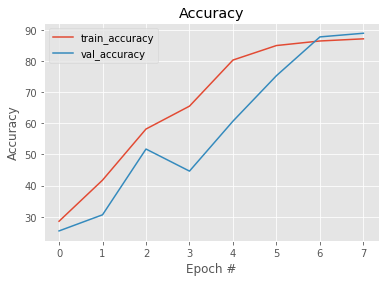

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
plt.style.use("ggplot")
plt.figure()
N = 8
plt.plot(np.arange(0, N),acc_values, label="train_accuracy")
plt.plot(np.arange(0, N),val_accuracy_values, label="val_accuracy")
plt.title("Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="upper left")
plt.show()

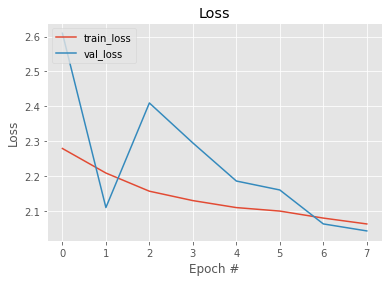

In [ ]:
plt.style.use("ggplot")
plt.figure()
N = 8
plt.plot(np.arange(0, N),loss_values, label="train_loss")
plt.plot(np.arange(0, N),val_loss_values, label="val_loss")
plt.title("Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="upper left")
plt.show()

In [ ]:
import numpy as np
import os
import pandas as pd
import tensorflow as tf
import shutil
from keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# Reloading the saved model to make predictions
model_caps_pred = tf.keras.models.load_model('./checkpoint_capsnet.h5')

In [ ]:
test_folder_path = './test_images'

if not os.path.exists(test_folder_path):
    os.mkdir(test_folder_path) 

In [ ]:
test_ds_path = '/content/drive/MyDrive/plant-pathology-2021-fgvc8/test_images'
test_dir_path = './test_images/all_classes'

if not os.path.exists(test_dir_path):
    shutil.copytree(test_ds_path, test_dir_path)

In [ ]:
_, _, files = next(os.walk(test_dir_path))
file_count = len(files)

print("Number of pictures: ", file_count)
print("Picture name: ", files)

Number of pictures:  14
Picture name:  ['85f8cb619c66b863.jpg', 'ad8770db05586b59.jpg', 'c7b03e718489f3ca.jpg', 'IMG_20211020_174743.jpg', 'IMG_20211020_174831.jpg', 'IMG_20211020_175040.jpg', 'IMG_20211020_175132.jpg', 'IMG_20211020_175253.jpg', 'IMG_20211020_175313.jpg', 'IMG_20211020_175324.jpg', 'IMG_20211020_175345.jpg', 'IMG_20211020_175417.jpg', 'IMG_20211020_175526.jpg', 'IMG_20211020_175840.jpg']


In [ ]:
test_image_generator = ImageDataGenerator(rescale=1./255)

In [ ]:
test_folder_path = './test_images'

In [ ]:
test_generator = test_image_generator.flow_from_directory(
                                        directory=test_folder_path,
                                        target_size=(TARGET_SIZE, TARGET_SIZE),
                                        class_mode=None,
                                        shuffle=False
                                        )

Found 14 images belonging to 1 classes.


In [ ]:
pred_caps = model_caps_pred.predict_generator(test_generator, verbose=1)
print(pred_caps)

<ipython-input-16-bbb8f930792c>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  pred_caps = model_caps_pred.predict_generator(test_generator, verbose=1)


1/1 [==============================] - 7s 7s/step
[[0.07068383 0.0222284  0.02246486 0.05018527 0.02189673 0.02655526
  0.14188178 0.03019878 0.02704448 0.5260869  0.03558008 0.02519357]
 [0.02543688 0.02306785 0.0246384  0.61849314 0.10968436 0.03079869
  0.02797146 0.02539587 0.02625956 0.0354955  0.02808239 0.02467586]
 [0.08786069 0.45899954 0.03586245 0.02838067 0.03162624 0.02825498
  0.08349542 0.03885389 0.04284796 0.0503738  0.07406417 0.03938023]
 [0.00838337 0.00853797 0.01012315 0.8919116  0.00932062 0.01125612
  0.00738281 0.01327052 0.0111676  0.00604215 0.00882359 0.01378045]
 [0.09305368 0.06389616 0.02714012 0.0744563  0.02638111 0.02627181
  0.15593266 0.03245124 0.02806878 0.39314604 0.05098521 0.02821687]
 [0.03024266 0.0269911  0.02435982 0.56457454 0.0218991  0.0233364
  0.03512385 0.02340394 0.02361608 0.17612775 0.0254773  0.02484747]
 [0.11322894 0.04473826 0.03404785 0.02636628 0.02973723 0.03052512
  0.06048042 0.0374308  0.03312656 0.4756178  0.07528823 0.03

In [ ]:
# making predictions on the testing image data
predicted_class_indices = np.argmax(pred_caps, axis=1)
print("Predicted class indices:", predicted_class_indices)

labels_dict = ({'scab' : 0, 'healthy' : 1, 'frog_eye_leaf_spot' : 2, 'rust' : 3, 'complex' : 4, 'powdery_mildew' : 5, 'scab frog_eye_leaf_spot' : 6, 'scab frog_eye_leaf_spot complex' : 7, 'frog_eye_leaf_spot complex' : 8,'rust frog_eye_leaf_spot' : 9,'rust complex' : 10,'powdery_mildew complex' : 11})

labels = dict((v,k) for k,v in labels_dict.items())
predictions = [labels[k] for k in predicted_class_indices]
print("Predicted class:", predictions)

Predicted class indices: [9 3 1 3 9 3 9 3 6 9 9 6 0 1]
Predicted class: ['rust frog_eye_leaf_spot', 'rust', 'healthy', 'rust', 'rust frog_eye_leaf_spot', 'rust', 'rust frog_eye_leaf_spot', 'rust', 'scab frog_eye_leaf_spot', 'rust frog_eye_leaf_spot', 'rust frog_eye_leaf_spot', 'scab frog_eye_leaf_spot', 'scab', 'healthy']


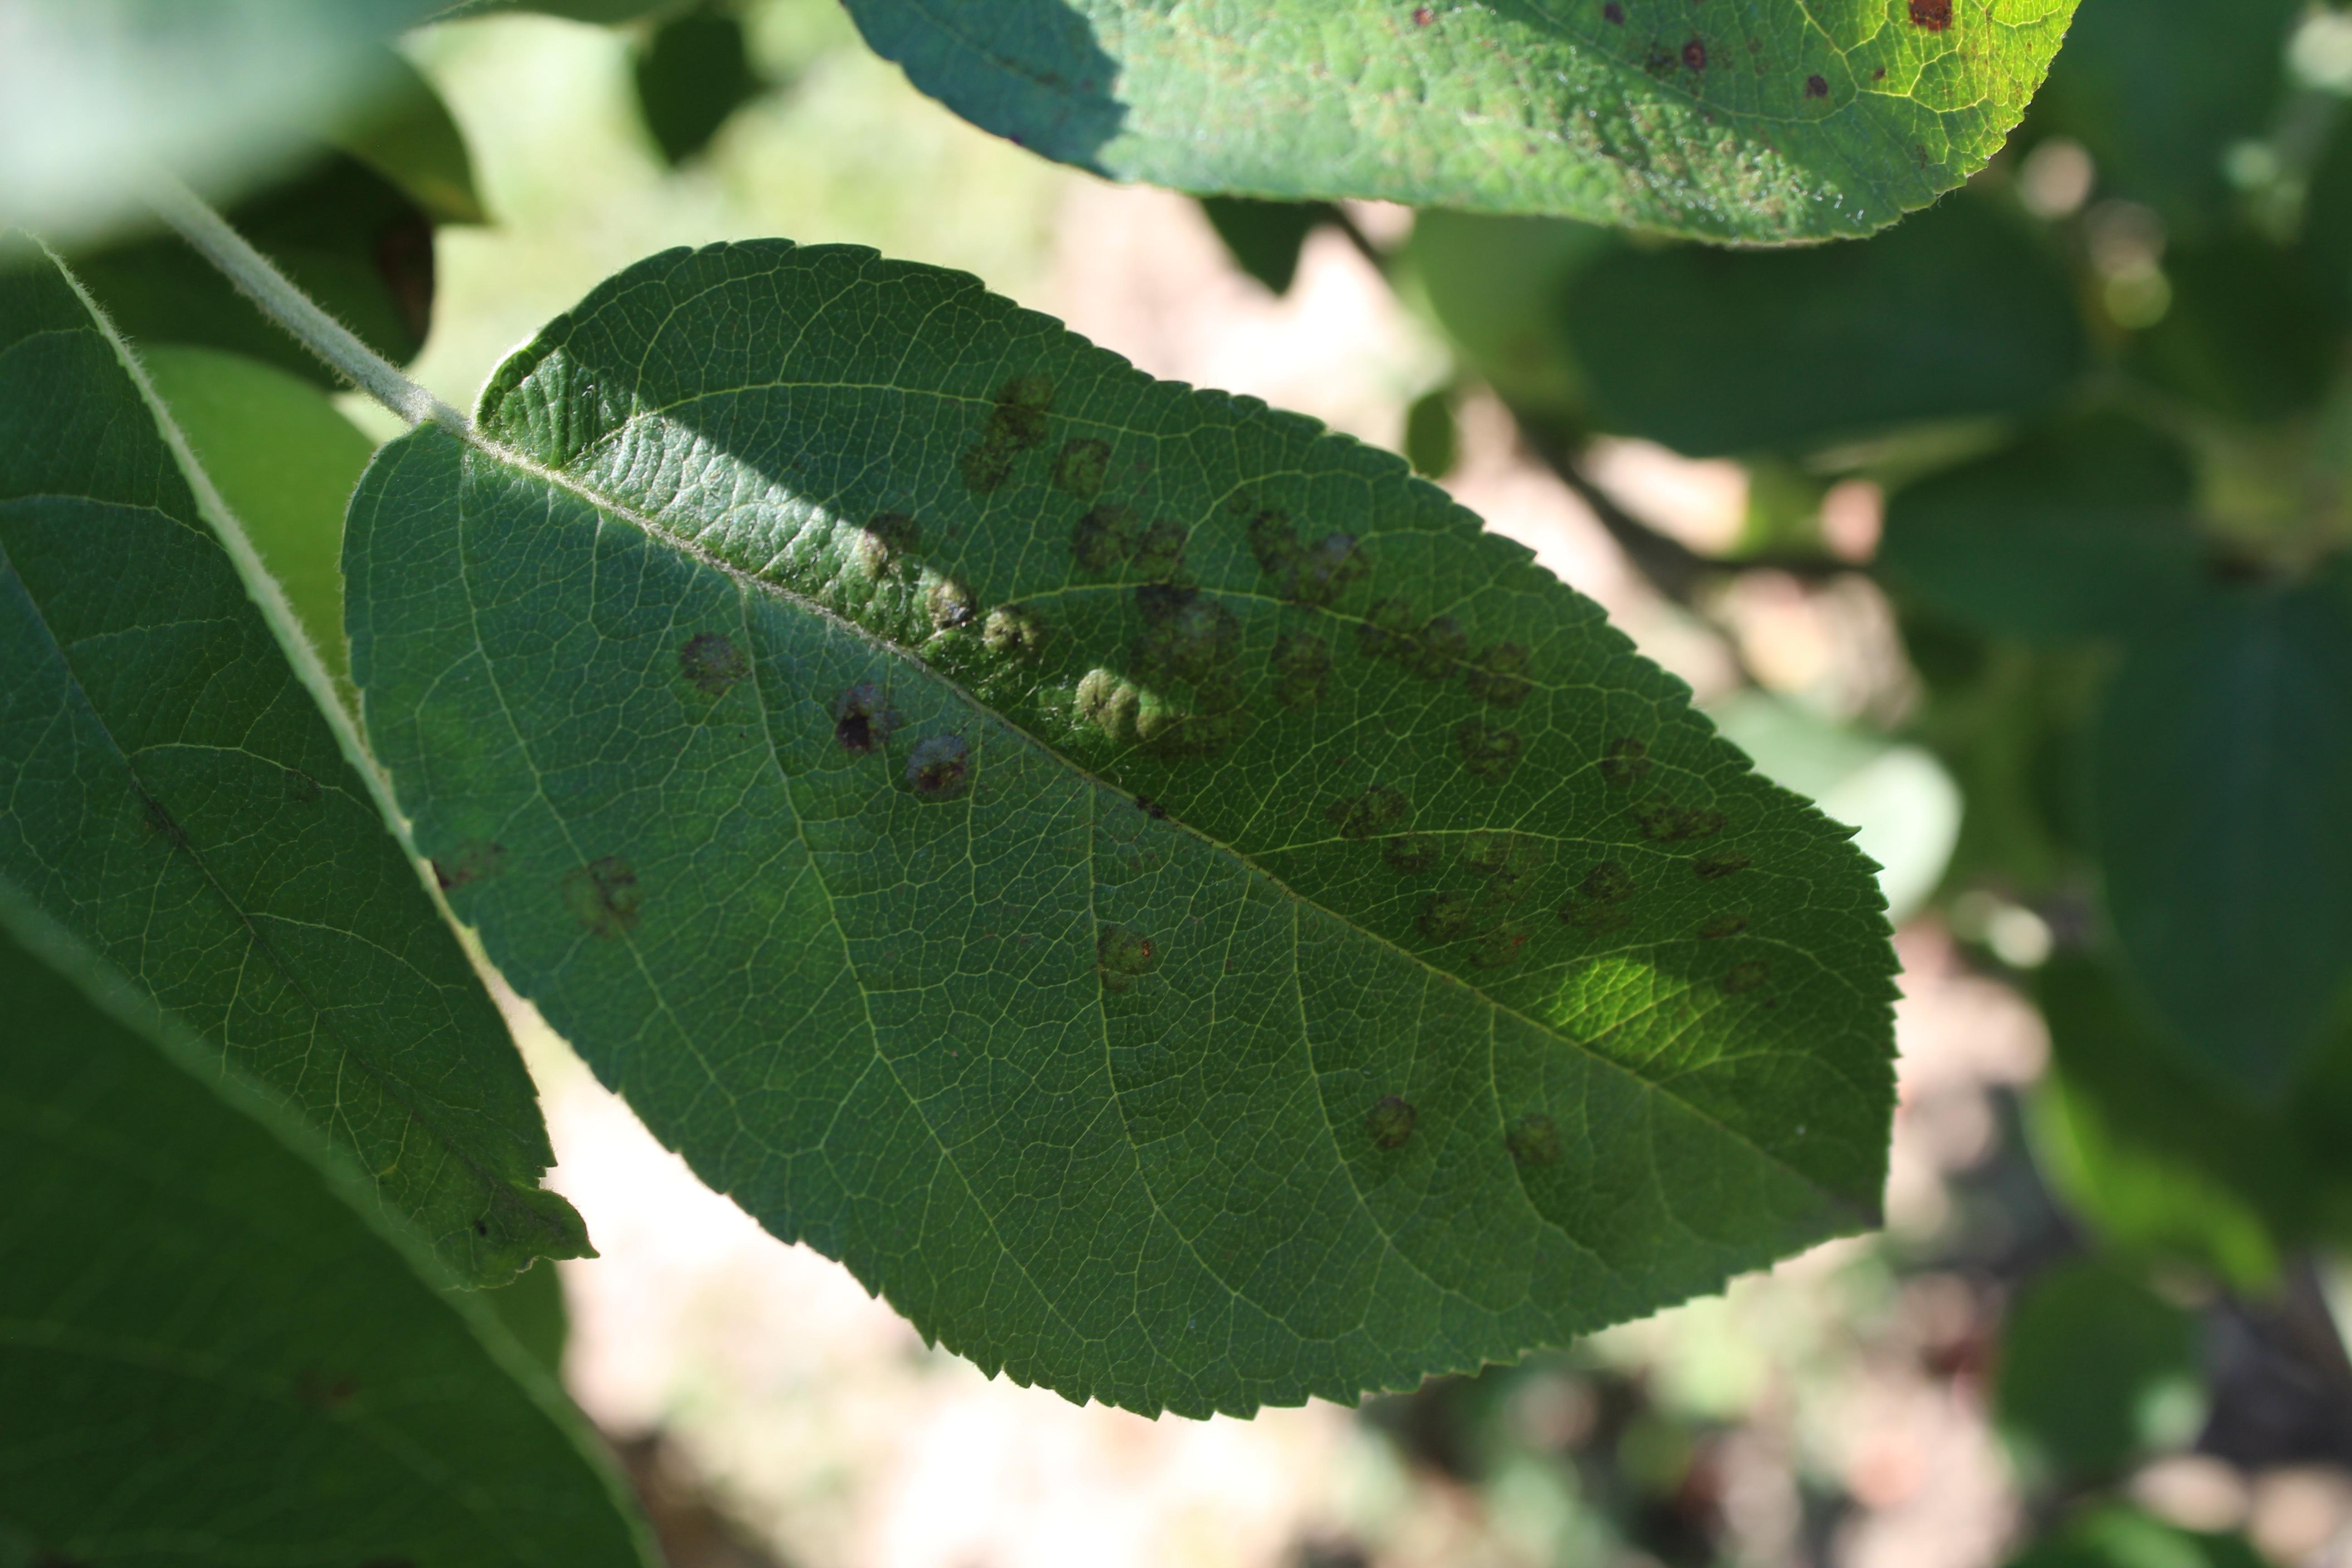

In [ ]:
from IPython.display import Image
Image(filename='D:\\EfficentNet_Apple\\plant-pathology-2021-fgvc8\\test_images\\85f8cb619c66b863.jpg', width = 250, height= 250)


In [ ]:
print("Predicted class:", predictions[0])

Predicted class: rust frog_eye_leaf_spot


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

Y_pred = model_caps_pred.predict_generator(valid_datagen, valid_datagen.samples // valid_datagen.batch_size + 5)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(valid_datagen.classes, y_pred))

<ipython-input-52-fcd22fe8fa19>:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = model_caps_pred.predict_generator(valid_datagen, valid_datagen.samples // valid_datagen.batch_size + 5)


Confusion Matrix
[[ 22  55   0  75  34   0  33   0   0  88   0   0]
 [ 47  97   0 139  52   0  63   0   0 155   1   0]
 [  4   3   0   7   1   0   2   0   0   1   0   0]
 [ 65 149   0 174  90   0  83   0   0 253   0   0]
 [ 32  51   0  65  50   0  32   0   0 107   0   0]
 [  3   3   0   4   2   0   1   0   0   7   0   0]
 [ 33  60   0  89  51   0  45   0   0 121   0   0]
 [  1   3   0   1   2   0   2   0   0   3   0   0]
 [  3   3   0   5   1   0   4   0   0   8   0   0]
 [ 89 181   0 282 103   0 130   0   0 323   0   0]
 [ 11  18   0  26  12   0  11   0   0  27   0   0]
 [  1   4   0  12   1   0   4   0   0   6   0   0]]


In [ ]:
#displaying the classification report including values for Precision, Recall, F1-score and Support for each disease class
target_names = list(train_datagen.class_indices.keys()) # Classes
print(classification_report(valid_datagen.classes, y_pred, target_names=target_names))

                                 precision    recall  f1-score   support

                        complex       0.07      0.07      0.07       307
             frog_eye_leaf_spot       0.15      0.18      0.16       554
     frog_eye_leaf_spot complex       0.00      0.00      0.00        18
                        healthy       0.20      0.21      0.21       814
                 powdery_mildew       0.13      0.15      0.14       337
         powdery_mildew complex       0.00      0.00      0.00        20
                           rust       0.11      0.11      0.11       399
                   rust complex       0.00      0.00      0.00        12
        rust frog_eye_leaf_spot       0.00      0.00      0.00        24
                           scab       0.29      0.29      0.29      1108
        scab frog_eye_leaf_spot       0.00      0.00      0.00       105
scab frog_eye_leaf_spot complex       0.00      0.00      0.00        28

                       accuracy                  

C:\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


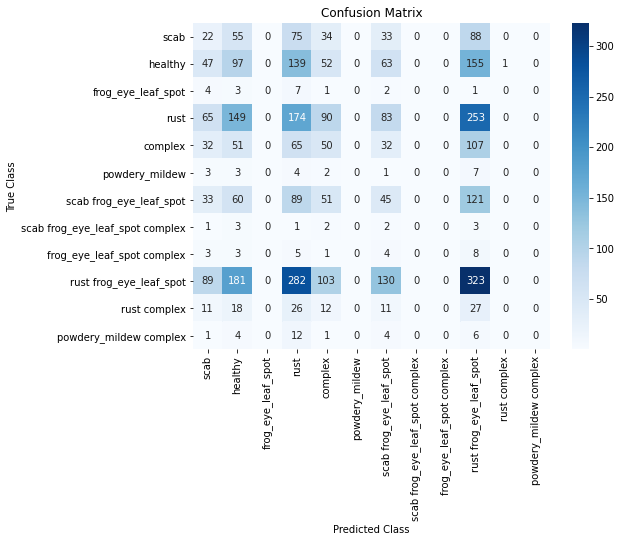

In [ ]:
#displaying the confusion matrix
import seaborn as sns

cm = confusion_matrix(valid_datagen.classes, y_pred)
labels = ['scab', 'healthy', 'frog_eye_leaf_spot', 'rust','complex', 'powdery_mildew','scab frog_eye_leaf_spot','scab frog_eye_leaf_spot complex','frog_eye_leaf_spot complex','rust frog_eye_leaf_spot','rust complex','powdery_mildew complex']
plt.figure(figsize=(8,6))
sns.heatmap(cm,xticklabels=labels, yticklabels=labels, annot=True, fmt='d', cmap="Blues", vmin = 0.2);
plt.title('Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()